In [123]:
# Import Libraries
import os # for opearating system interaction
import pandas as pd # for working with tabular data 
import geopandas as gpd # for GIS analysis
from shapely.geometry import Point # Allows the creation of gpkg files from xy data
import numpy as np # numerical calculation
from matplotlib import pyplot as plt # for plotting
import matplotlib
import matplotlib_map_utils as tmap

In [124]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [125]:
#Load the datasets
tx_2022 = pd.read_csv("D:\\Mini Project GIS\\NBI_TX_2022.csv")
tx_2023 = pd.read_csv("D:\\Mini Project GIS\\NBI_TX_2023.csv")

# Print columns of loaded datasets to confirm presence of LAT_016 and LONG_017
print("Columns in tx_2022:", tx_2022.columns)
print("Columns in tx_2023:", tx_2023.columns)


C:\Users\tadib\AppData\Local\Temp\ipykernel_29660\688515736.py:2: DtypeWarning: Columns (5,75,96) have mixed types. Specify dtype option on import or set low_memory=False.
  tx_2022 = pd.read_csv("D:\\Mini Project GIS\\NBI_TX_2022.csv")


Columns in tx_2022: Index(['STATE_CODE_001', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A',
       'ROUTE_PREFIX_005B', 'SERVICE_LEVEL_005C', 'ROUTE_NUMBER_005D',
       'DIRECTION_005E', 'HIGHWAY_DISTRICT_002', 'COUNTY_CODE_003',
       'PLACE_CODE_004',
       ...
       'BRIDGE_LEN_IND_112', 'SCOUR_CRITICAL_113', 'FUTURE_ADT_114',
       'YEAR_OF_FUTURE_ADT_115', 'MIN_NAV_CLR_MT_116', 'FED_AGENCY',
       'SUBMITTED_BY', 'BRIDGE_CONDITION', 'LOWEST_RATING', 'DECK_AREA'],
      dtype='object', length=123)
Columns in tx_2023: Index(['STATE_CODE_001', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A',
       'ROUTE_PREFIX_005B', 'SERVICE_LEVEL_005C', 'ROUTE_NUMBER_005D',
       'DIRECTION_005E', 'HIGHWAY_DISTRICT_002', 'COUNTY_CODE_003',
       'PLACE_CODE_004',
       ...
       'BRIDGE_LEN_IND_112', 'SCOUR_CRITICAL_113', 'FUTURE_ADT_114',
       'YEAR_OF_FUTURE_ADT_115', 'MIN_NAV_CLR_MT_116', 'FED_AGENCY',
       'SUBMITTED_BY', 'BRIDGE_CONDITION', 'LOWEST_RATING', 'DECK_AREA'],
      dtype='o

C:\Users\tadib\AppData\Local\Temp\ipykernel_29660\688515736.py:3: DtypeWarning: Columns (5,75,96) have mixed types. Specify dtype option on import or set low_memory=False.
  tx_2023 = pd.read_csv("D:\\Mini Project GIS\\NBI_TX_2023.csv")


In [126]:
# Function to convert DMS to Decimal Degrees and adjust based on WGS 84 for Texas
def dms_to_dd(dms_value, is_latitude=True):
    degrees = int(dms_value / 1000000)
    minutes = int((dms_value - degrees * 1000000) / 10000)
    seconds = (dms_value - degrees * 1000000 - minutes * 10000) / 100
    
    decimal_degrees = degrees + (minutes / 60) + (seconds / 3600)
    
    # For latitudes, positive in the northern hemisphere
    if is_latitude:
        return decimal_degrees  # Texas is in the northern hemisphere, so positive latitude
    
    # For longitudes, negative in the western hemisphere
    else:
        return -decimal_degrees  # Texas is in the western hemisphere, so negative longitude

In [127]:
# Merge datasets on the structure number
merged_bridges = pd.merge(tx_2023, tx_2022, on='STRUCTURE_NUMBER_008', how='left', suffixes=('_2023', '_2022'), indicator=True)

# Print columns after merging
print("Columns in merged_bridges:", merged_bridges.columns)



Columns in merged_bridges: Index(['STATE_CODE_001_2023', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A_2023',
       'ROUTE_PREFIX_005B_2023', 'SERVICE_LEVEL_005C_2023',
       'ROUTE_NUMBER_005D_2023', 'DIRECTION_005E_2023',
       'HIGHWAY_DISTRICT_002_2023', 'COUNTY_CODE_003_2023',
       'PLACE_CODE_004_2023',
       ...
       'SCOUR_CRITICAL_113_2022', 'FUTURE_ADT_114_2022',
       'YEAR_OF_FUTURE_ADT_115_2022', 'MIN_NAV_CLR_MT_116_2022',
       'FED_AGENCY_2022', 'SUBMITTED_BY_2022', 'BRIDGE_CONDITION_2022',
       'LOWEST_RATING_2022', 'DECK_AREA_2022', '_merge'],
      dtype='object', length=246)


In [128]:
# Find bridges that are in 2023 but not in 2022
new_bridges_2023 = tx_2023[~tx_2023['STRUCTURE_NUMBER_008'].isin(tx_2022['STRUCTURE_NUMBER_008'])]

In [129]:
# After merging the datasets, print the columns of new_bridges_2023
print("Initial columns in new_bridges_2023:", new_bridges_2023.columns)

# Convert latitude and longitude from DMS to Decimal Degrees with proper sign
new_bridges_2023['LAT_016_dd'] = new_bridges_2023['LAT_016'].apply(lambda x: dms_to_dd(x, is_latitude=True))
new_bridges_2023['LONG_017_dd'] = new_bridges_2023['LONG_017'].apply(lambda x: dms_to_dd(x, is_latitude=False))

# After conversion, print the columns to confirm they exist
print("Columns after conversion to decimal degrees:", new_bridges_2023.columns)

# Drop rows with missing latitude or longitude after conversion
# Use the new columns for dropping missing values
new_bridges_2023 = new_bridges_2023.dropna(subset=['LAT_016_dd', 'LONG_017_dd'])

# Optionally, print the shape of the DataFrame after dropping to see how many rows were removed
print("Shape of new_bridges_2023 after dropping missing values:", new_bridges_2023.shape)


Initial columns in new_bridges_2023: Index(['STATE_CODE_001', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A',
       'ROUTE_PREFIX_005B', 'SERVICE_LEVEL_005C', 'ROUTE_NUMBER_005D',
       'DIRECTION_005E', 'HIGHWAY_DISTRICT_002', 'COUNTY_CODE_003',
       'PLACE_CODE_004',
       ...
       'BRIDGE_LEN_IND_112', 'SCOUR_CRITICAL_113', 'FUTURE_ADT_114',
       'YEAR_OF_FUTURE_ADT_115', 'MIN_NAV_CLR_MT_116', 'FED_AGENCY',
       'SUBMITTED_BY', 'BRIDGE_CONDITION', 'LOWEST_RATING', 'DECK_AREA'],
      dtype='object', length=123)
Columns after conversion to decimal degrees: Index(['STATE_CODE_001', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A',
       'ROUTE_PREFIX_005B', 'SERVICE_LEVEL_005C', 'ROUTE_NUMBER_005D',
       'DIRECTION_005E', 'HIGHWAY_DISTRICT_002', 'COUNTY_CODE_003',
       'PLACE_CODE_004',
       ...
       'FUTURE_ADT_114', 'YEAR_OF_FUTURE_ADT_115', 'MIN_NAV_CLR_MT_116',
       'FED_AGENCY', 'SUBMITTED_BY', 'BRIDGE_CONDITION', 'LOWEST_RATING',
       'DECK_AREA', 'LAT_016_dd', 'LO

C:\Users\tadib\AppData\Local\Temp\ipykernel_29660\1609281902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bridges_2023['LAT_016_dd'] = new_bridges_2023['LAT_016'].apply(lambda x: dms_to_dd(x, is_latitude=True))
C:\Users\tadib\AppData\Local\Temp\ipykernel_29660\1609281902.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bridges_2023['LONG_017_dd'] = new_bridges_2023['LONG_017'].apply(lambda x: dms_to_dd(x, is_latitude=False))


In [130]:
# Find bridges that are in 2023 but not in 2022
new_bridges_2023 = merged_bridges[merged_bridges['_merge'] == 'left_only']

# Check the columns in new_bridges_2023
print("Columns in new_bridges_2023:", new_bridges_2023.columns.tolist())

# Identify the correct names for latitude and longitude
# Update these based on the actual names from the print output above
lat_col = 'LAT_016_2023'  # Change this to the correct column name if needed
long_col = 'LONG_017_2023'  # Change this to the correct column name if needed

Columns in new_bridges_2023: ['STATE_CODE_001_2023', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A_2023', 'ROUTE_PREFIX_005B_2023', 'SERVICE_LEVEL_005C_2023', 'ROUTE_NUMBER_005D_2023', 'DIRECTION_005E_2023', 'HIGHWAY_DISTRICT_002_2023', 'COUNTY_CODE_003_2023', 'PLACE_CODE_004_2023', 'FEATURES_DESC_006A_2023', 'CRITICAL_FACILITY_006B_2023', 'FACILITY_CARRIED_007_2023', 'LOCATION_009_2023', 'MIN_VERT_CLR_010_2023', 'KILOPOINT_011_2023', 'BASE_HWY_NETWORK_012_2023', 'LRS_INV_ROUTE_013A_2023', 'SUBROUTE_NO_013B_2023', 'LAT_016_2023', 'LONG_017_2023', 'DETOUR_KILOS_019_2023', 'TOLL_020_2023', 'MAINTENANCE_021_2023', 'OWNER_022_2023', 'FUNCTIONAL_CLASS_026_2023', 'YEAR_BUILT_027_2023', 'TRAFFIC_LANES_ON_028A_2023', 'TRAFFIC_LANES_UND_028B_2023', 'ADT_029_2023', 'YEAR_ADT_030_2023', 'DESIGN_LOAD_031_2023', 'APPR_WIDTH_MT_032_2023', 'MEDIAN_CODE_033_2023', 'DEGREES_SKEW_034_2023', 'STRUCTURE_FLARED_035_2023', 'RAILINGS_036A_2023', 'TRANSITIONS_036B_2023', 'APPR_RAIL_036C_2023', 'APPR_RAIL_END_036D

In [131]:
# Now, convert latitude and longitude from DMS to Decimal Degrees with proper sign
new_bridges_2023['LAT_016_dd'] = new_bridges_2023[lat_col].apply(lambda x: dms_to_dd(x, is_latitude=True))
new_bridges_2023['LONG_017_dd'] = new_bridges_2023[long_col].apply(lambda x: dms_to_dd(x, is_latitude=False))

# Print columns after conversion to confirm the names
print("Columns in new_bridges_2023 after conversion to decimal degrees:", new_bridges_2023.columns)

# Drop rows with missing latitude or longitude after conversion
new_bridges_2023 = new_bridges_2023.dropna(subset=['LAT_016_dd', 'LONG_017_dd'])

# Create a GeoDataFrame with the converted coordinates
geometry = [Point(xy) for xy in zip(new_bridges_2023['LONG_017_dd'], new_bridges_2023['LAT_016_dd'])]
gdf = gpd.GeoDataFrame(new_bridges_2023, geometry=geometry)

# Optionally, print the shape of the GeoDataFrame
print("Shape of GeoDataFrame:", gdf.shape)

Columns in new_bridges_2023 after conversion to decimal degrees: Index(['STATE_CODE_001_2023', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A_2023',
       'ROUTE_PREFIX_005B_2023', 'SERVICE_LEVEL_005C_2023',
       'ROUTE_NUMBER_005D_2023', 'DIRECTION_005E_2023',
       'HIGHWAY_DISTRICT_002_2023', 'COUNTY_CODE_003_2023',
       'PLACE_CODE_004_2023',
       ...
       'YEAR_OF_FUTURE_ADT_115_2022', 'MIN_NAV_CLR_MT_116_2022',
       'FED_AGENCY_2022', 'SUBMITTED_BY_2022', 'BRIDGE_CONDITION_2022',
       'LOWEST_RATING_2022', 'DECK_AREA_2022', '_merge', 'LAT_016_dd',
       'LONG_017_dd'],
      dtype='object', length=248)
Shape of GeoDataFrame: (982, 249)


C:\Users\tadib\AppData\Local\Temp\ipykernel_29660\2073157641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bridges_2023['LAT_016_dd'] = new_bridges_2023[lat_col].apply(lambda x: dms_to_dd(x, is_latitude=True))
C:\Users\tadib\AppData\Local\Temp\ipykernel_29660\2073157641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bridges_2023['LONG_017_dd'] = new_bridges_2023[long_col].apply(lambda x: dms_to_dd(x, is_latitude=False))


In [132]:
print("Columns in new_bridges_2023 after conversion to decimal degrees:", new_bridges_2023.columns)

# Drop rows with missing latitude or longitude after conversion
new_bridges_2023 = new_bridges_2023.dropna(subset=['LAT_016_dd', 'LONG_017_dd'])

# Optionally, print the shape of the DataFrame after dropping to see how many rows were removed
print("Shape of new_bridges_2023 after dropping missing values:", new_bridges_2023.shape)

Columns in new_bridges_2023 after conversion to decimal degrees: Index(['STATE_CODE_001_2023', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A_2023',
       'ROUTE_PREFIX_005B_2023', 'SERVICE_LEVEL_005C_2023',
       'ROUTE_NUMBER_005D_2023', 'DIRECTION_005E_2023',
       'HIGHWAY_DISTRICT_002_2023', 'COUNTY_CODE_003_2023',
       'PLACE_CODE_004_2023',
       ...
       'YEAR_OF_FUTURE_ADT_115_2022', 'MIN_NAV_CLR_MT_116_2022',
       'FED_AGENCY_2022', 'SUBMITTED_BY_2022', 'BRIDGE_CONDITION_2022',
       'LOWEST_RATING_2022', 'DECK_AREA_2022', '_merge', 'LAT_016_dd',
       'LONG_017_dd'],
      dtype='object', length=248)
Shape of new_bridges_2023 after dropping missing values: (982, 248)


In [133]:
# Assuming 'Bridge_ID' is the unique identifier for each bridge
bridges_2022 = set(tx_2022['STRUCTURE_NUMBER_008'])
bridges_2023 = set(tx_2023['STRUCTURE_NUMBER_008'])

In [134]:
# Set the CRS to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

,STATE_CODE_001_2023,STRUCTURE_NUMBER_008,RECORD_TYPE_005A_2023,ROUTE_PREFIX_005B_2023,SERVICE_LEVEL_005C_2023,ROUTE_NUMBER_005D_2023,DIRECTION_005E_2023,HIGHWAY_DISTRICT_002_2023,COUNTY_CODE_003_2023,PLACE_CODE_004_2023,...,MIN_NAV_CLR_MT_116_2022,FED_AGENCY_2022,SUBMITTED_BY_2022,BRIDGE_CONDITION_2022,LOWEST_RATING_2022,DECK_AREA_2022,_merge,LAT_016_dd,LONG_017_dd,geometry
9,48,000021594-62610,1,6,0,0,0,2,203,0,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,32.680500,-94.145833,POINT (-94.14583 32.6805)
115,48,010600AA2130001,1,4,1,2130,0,1,119,0,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,33.371656,-95.774397,POINT (-95.7744 33.37166)
584,48,010920004702684,1,2,1,75,1,1,181,39200,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,33.628550,-96.613514,POINT (-96.61351 33.62855)
585,48,010920004702685,1,2,1,75,3,1,181,39200,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,33.628522,-96.613681,POINT (-96.61368 33.62852)
586,48,010920004702686,1,2,1,75,1,1,181,39200,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,33.637911,-96.616428,POINT (-96.61643 33.63791)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56296,48,DAPFORHOO0BVM20,1,8,0,00000,0,9,99,26736,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,31.155450,-97.816239,POINT (-97.81624 31.15545)
56310,48,NCA1,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,32.717314,-96.936814,POINT (-96.93681 32.71731)
56311,48,NCA2,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,32.713853,-96.934181,POINT (-96.93418 32.71385)
56312,48,NCA3,1,6,0,00000,0,0,113,19000,...,NaN,NaN,NaN,NaN,NaN,NaN,left_only,32.712667,-96.937056,POINT (-96.93706 32.71267)


In [135]:
# Load the map from the "Conus" file
map_gdf = gpd.read_file("D:\\Mini Project GIS\\Conus.gpkg")

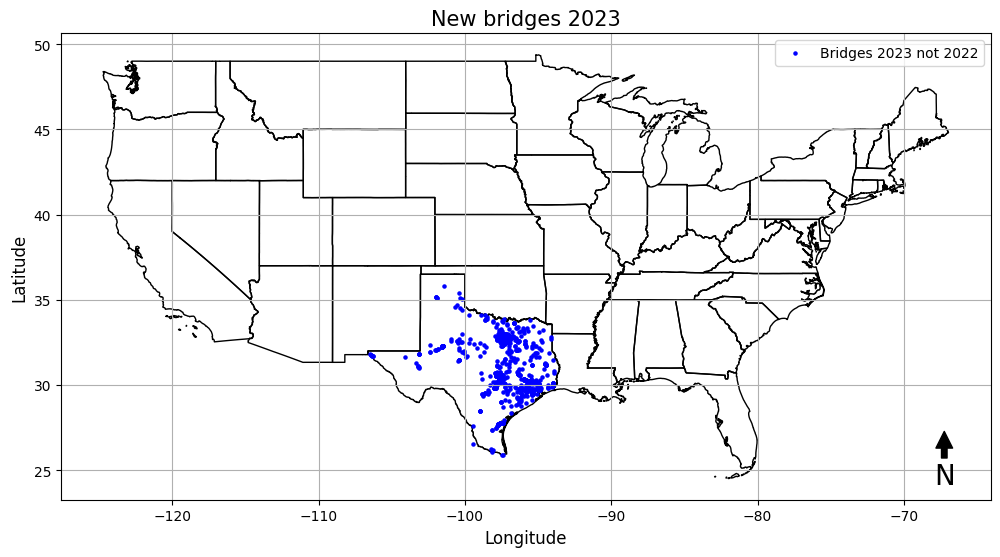

In [136]:
# Plotting the map
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, color='blue', marker='o', markersize=1,)

# Plot the Conus83 map as the base layer
map_gdf.plot(ax=ax, linewidth=1, edgecolor='black', facecolor='none')

# Plot the bridges on top of the map
gdf.plot(ax=ax, color='blue', marker='o', markersize=5, label='Bridges 2023 not 2022')

# Customize the map
ax.set_title('New bridges 2023', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True)

# Add a north arrow
x, y, arrow_length = 0.95, 0.15, 0.1  # Position and length of the arrow (in axis coordinates)
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', shrink=0.05),
            ha='center', va='center', fontsize=20, xycoords='axes fraction')

# Display the plot
plt.show()

In [137]:
# Load datasets (simulated data as provided earlier)
tx_2022 = pd.DataFrame({
    "STRUCTURE_NUMBER_008": [1, 2, 3],
    "AGE": [50, 60, 45],
    "TRAFFIC_LANES_ON_028A": [2, 4, 2],
    "ADT_029": [1000, 2500, 400],
    "BRIDGE_CONDITION": [0, 1, 0]})

tx_2023 = pd.DataFrame({
    "STRUCTURE_NUMBER_008": [1, 2, 4],
    "AGE": [51, 61, 20],
    "TRAFFIC_LANES_ON_028A": [2, 4, 3],
    "ADT_029": [1100, 2550, 1500],
    "BRIDGE_CONDITION": [0, 1, 0]
})

# Merge datasets on the structure number
merged_bridges = pd.merge(tx_2023, tx_2022, on='STRUCTURE_NUMBER_008', how='left', suffixes=('_2023', '_2022'))

# Select features and target variable for logistic regression
features = ['AGE_2023', 'TRAFFIC_LANES_ON_028A_2023', 'ADT_029_2023']
X = merged_bridges[features]
y = merged_bridges['BRIDGE_CONDITION_2023']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Predict probabilities
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
print("Predicted probabilities:", y_pred_prob)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1

Predicted probabilities: [5.27065003e-09]


In [138]:
texas_map_gdf = gpd.read_file("D:\\Mini Project GIS\\texas_state.gpkg")

In [139]:
# Reproject the data to WGS84 (EPSG:4326)
texas_wgs84 = texas_map_gdf.to_crs(epsg=4326)

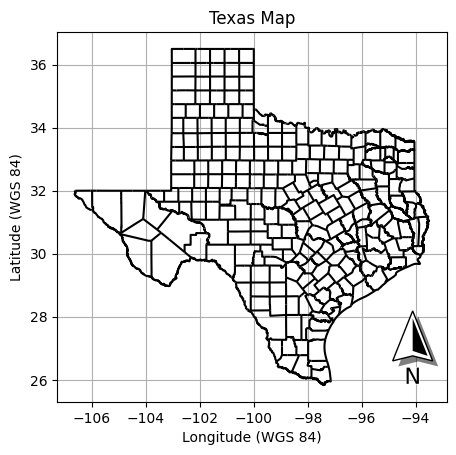

In [140]:
#Visualize the overlay result (you can customise this based on your needs)
fig = plt.figure()
ax1 = fig.add_subplot() #we have multiple layers being added, so when we have to plot multiple layers on the plot, we need to make sure all of them are plotted on the same axis.
texas_wgs84.plot (facecolor='white', edgecolor='black', ax=ax1) #ax=ax1 - overlaping axis. 
texas_wgs84.plot(ax=ax1, color='none', markersize=1)
tmap.north_arrow.north_arrow(ax=ax1, location='lower right', rotation={'degrees':0}) 
ax1.set_xlabel('Longitude (WGS 84)')
ax1.set_ylabel('Latitude (WGS 84)')
plt.grid()
plt.title ('Texas Map')
plt.show()

In [141]:
tx_2023_new = pd.read_csv("D:\\Mini Project GIS\\new_bridges_2023.csv")
# Print columns of loaded datasets to confirm presence of LAT_016 and LONG_017
print("Columns in tx_2023:", tx_2023_new.columns)

Columns in tx_2023: Index(['STATE_CODE_001', 'STRUCTURE_NUMBER_008', 'RECORD_TYPE_005A',
       'ROUTE_PREFIX_005B', 'SERVICE_LEVEL_005C', 'ROUTE_NUMBER_005D',
       'DIRECTION_005E', 'HIGHWAY_DISTRICT_002', 'COUNTY_CODE_003',
       'PLACE_CODE_004',
       ...
       'BRIDGE_LEN_IND_112', 'SCOUR_CRITICAL_113', 'FUTURE_ADT_114',
       'YEAR_OF_FUTURE_ADT_115', 'MIN_NAV_CLR_MT_116', 'FED_AGENCY',
       'SUBMITTED_BY', 'BRIDGE_CONDITION', 'LOWEST_RATING', 'DECK_AREA'],
      dtype='object', length=123)


In [142]:
 # Identify the structure numbers in df_2023_new
structure_numbers_to_remove = tx_2023_new['STRUCTURE_NUMBER_008']

In [143]:
tx_2023_new['AGE'] = 2024 - tx_2023_new['YEAR_BUILT_027']

In [144]:
#Bridge surved in 2023 and 2022, but removing those which were not surved in 2022.
diff_23_22 = tx_2023_new[['STRUCTURE_NUMBER_008', 'LAT_016', 'LONG_017', 'DECK_COND_058', 
                  'SUPERSTRUCTURE_COND_059', 'CHANNEL_COND_061', 'ADT_029', 
                   'DECK_AREA', 'MAX_SPAN_LEN_MT_048','AGE']].copy()

In [145]:
print(diff_23_22)

    STRUCTURE_NUMBER_008   LAT_016  LONG_017 DECK_COND_058  \
0        000021594-62610  32404980  94084500             8   
1        010600AA2130001  33221796  95462783             9   
2        010920004702684  33374278  96364865             9   
3        010920004702685  33374268  96364925             9   
4        010920004702686  33381648  96365914             9   
..                   ...       ...       ...           ...   
977      DAPFORHOO0BVM20  31091962  97485846             8   
978      NCA1             32430233  96561253             7   
979      NCA2             32424987  96560305             N   
980      NCA3             32424560  96561340             N   
981      NCA6             29283700  98252680             N   

    SUPERSTRUCTURE_COND_059 CHANNEL_COND_061  ADT_029  DECK_AREA  \
0                         8                7        0     127.98   
1                         9                9       40      97.60   
2                         9                N    559

In [146]:
tx_2023_new['AGE'] = 2024 - tx_2023_new['YEAR_BUILT_027']

In [147]:
#Bridge surved in 2023 were not surved in 2022.
tx_2023_new = tx_2023_new[['STRUCTURE_NUMBER_008', 'LAT_016', 'LONG_017', 'DECK_COND_058', 
                  'SUPERSTRUCTURE_COND_059', 'CHANNEL_COND_061', 'ADT_029', 
                   'DECK_AREA', 'MAX_SPAN_LEN_MT_048','AGE']].copy()

In [148]:
print(tx_2023_new)

    STRUCTURE_NUMBER_008   LAT_016  LONG_017 DECK_COND_058  \
0        000021594-62610  32404980  94084500             8   
1        010600AA2130001  33221796  95462783             9   
2        010920004702684  33374278  96364865             9   
3        010920004702685  33374268  96364925             9   
4        010920004702686  33381648  96365914             9   
..                   ...       ...       ...           ...   
977      DAPFORHOO0BVM20  31091962  97485846             8   
978      NCA1             32430233  96561253             7   
979      NCA2             32424987  96560305             N   
980      NCA3             32424560  96561340             N   
981      NCA6             29283700  98252680             N   

    SUPERSTRUCTURE_COND_059 CHANNEL_COND_061  ADT_029  DECK_AREA  \
0                         8                7        0     127.98   
1                         9                9       40      97.60   
2                         9                N    559

In [149]:
tx_2023_new.head()

,STRUCTURE_NUMBER_008,LAT_016,LONG_017,DECK_COND_058,SUPERSTRUCTURE_COND_059,CHANNEL_COND_061,ADT_029,DECK_AREA,MAX_SPAN_LEN_MT_048,AGE
0,000021594-62610,32404980,94084500,8,8,7,0,127.98,14.9,6
1,010600AA2130001,33221796,95462783,9,9,9,40,97.60,12.2,2
2,010920004702684,33374278,96364865,9,9,N,55900,1404.48,25.0,2
3,010920004702685,33374268,96364925,9,9,N,55900,1367.52,25.0,2
4,010920004702686,33381648,96365914,9,9,9,54500,20821.26,36.6,2


In [150]:
diff_23_22.head()

,STRUCTURE_NUMBER_008,LAT_016,LONG_017,DECK_COND_058,SUPERSTRUCTURE_COND_059,CHANNEL_COND_061,ADT_029,DECK_AREA,MAX_SPAN_LEN_MT_048,AGE
0,000021594-62610,32404980,94084500,8,8,7,0,127.98,14.9,6
1,010600AA2130001,33221796,95462783,9,9,9,40,97.60,12.2,2
2,010920004702684,33374278,96364865,9,9,N,55900,1404.48,25.0,2
3,010920004702685,33374268,96364925,9,9,N,55900,1367.52,25.0,2
4,010920004702686,33381648,96365914,9,9,9,54500,20821.26,36.6,2


In [151]:
columns_to_convert = ['DECK_COND_058', 'SUPERSTRUCTURE_COND_059', 'CHANNEL_COND_061', 
                      'ADT_029', 'DECK_AREA', 'MAX_SPAN_LEN_MT_048', 'AGE']

# Step 1: Replace 'N' values with 0 in the specified columns
tx_2023_new[columns_to_convert] = tx_2023_new[columns_to_convert].replace('N', 0)
tx_2023_new[columns_to_convert] = tx_2023_new[columns_to_convert].replace('NaN', 0)

# Step 1: Convert the specified columns to numeric, coercing any errors to NaN
tx_2023_new[columns_to_convert] = tx_2023_new[columns_to_convert].apply(
    lambda col: pd.to_numeric(col, errors='coerce')
)

In [152]:
columns_to_convert = ['DECK_COND_058', 'SUPERSTRUCTURE_COND_059', 'CHANNEL_COND_061', 
                      'ADT_029', 'DECK_AREA', 'MAX_SPAN_LEN_MT_048', 'AGE']

# Step 1: Replace 'N' values with 0 in the specified columns
diff_23_22[columns_to_convert] = diff_23_22[columns_to_convert].replace('N', 0)
diff_23_22[columns_to_convert] = diff_23_22[columns_to_convert].replace('NaN', 0)

# Step 1: Convert the specified columns to numeric, coercing any errors to NaN
diff_23_22[columns_to_convert] = diff_23_22[columns_to_convert].apply(
    lambda col: pd.to_numeric(col, errors='coerce')
)

In [153]:
diff_23_22.head()

,STRUCTURE_NUMBER_008,LAT_016,LONG_017,DECK_COND_058,SUPERSTRUCTURE_COND_059,CHANNEL_COND_061,ADT_029,DECK_AREA,MAX_SPAN_LEN_MT_048,AGE
0,000021594-62610,32404980,94084500,8,8,7,0,127.98,14.9,6
1,010600AA2130001,33221796,95462783,9,9,9,40,97.60,12.2,2
2,010920004702684,33374278,96364865,9,9,0,55900,1404.48,25.0,2
3,010920004702685,33374268,96364925,9,9,0,55900,1367.52,25.0,2
4,010920004702686,33381648,96365914,9,9,9,54500,20821.26,36.6,2


In [154]:
diff_23_22A = diff_23_22

In [155]:
diff_23_22A['DECK_COND_058'] = diff_23_22['DECK_COND_058'].apply(lambda x: 1 if x >= 5 else 0)
diff_23_22A['SUPERSTRUCTURE_COND_059'] = diff_23_22['SUPERSTRUCTURE_COND_059'].apply(lambda x: 1 if x >= 5 else 0)
diff_23_22A['CHANNEL_COND_061'] = diff_23_22['CHANNEL_COND_061'].apply(lambda x: 1 if x >= 5 else 0)

In [156]:
diff_23_22A.head()

,STRUCTURE_NUMBER_008,LAT_016,LONG_017,DECK_COND_058,SUPERSTRUCTURE_COND_059,CHANNEL_COND_061,ADT_029,DECK_AREA,MAX_SPAN_LEN_MT_048,AGE
0,000021594-62610,32404980,94084500,1,1,1,0,127.98,14.9,6
1,010600AA2130001,33221796,95462783,1,1,1,40,97.60,12.2,2
2,010920004702684,33374278,96364865,1,1,0,55900,1404.48,25.0,2
3,010920004702685,33374268,96364925,1,1,0,55900,1367.52,25.0,2
4,010920004702686,33381648,96365914,1,1,1,54500,20821.26,36.6,2


In [157]:
diff_23_newA = tx_2023_new

In [158]:
diff_23_newA['DECK_COND_058'] = tx_2023_new['DECK_COND_058'].apply(lambda x: 1 if x >= 5 else 0)
diff_23_newA['SUPERSTRUCTURE_COND_059'] = tx_2023_new['SUPERSTRUCTURE_COND_059'].apply(lambda x: 1 if x >= 5 else 0)
diff_23_newA['CHANNEL_COND_061'] = tx_2023_new['CHANNEL_COND_061'].apply(lambda x: 1 if x >= 5 else 0)

In [159]:
diff_23_newA.head()

,STRUCTURE_NUMBER_008,LAT_016,LONG_017,DECK_COND_058,SUPERSTRUCTURE_COND_059,CHANNEL_COND_061,ADT_029,DECK_AREA,MAX_SPAN_LEN_MT_048,AGE
0,000021594-62610,32404980,94084500,1,1,1,0,127.98,14.9,6
1,010600AA2130001,33221796,95462783,1,1,1,40,97.60,12.2,2
2,010920004702684,33374278,96364865,1,1,0,55900,1404.48,25.0,2
3,010920004702685,33374268,96364925,1,1,0,55900,1367.52,25.0,2
4,010920004702686,33381648,96365914,1,1,1,54500,20821.26,36.6,2


In [160]:
# Logsitic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [161]:
# Step 1: Prepare the input (independent) and output (dependent) variables from df_2023_2022A
X = diff_23_22A[['ADT_029', 'DECK_AREA', 'MAX_SPAN_LEN_MT_048', 'AGE']]  # Independent variables
y = diff_23_22A['DECK_COND_058']  # Dependent variable

# Step 2: Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create a pipeline that first imputes missing values and then fits the logistic regression model
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('logistic_regression', LogisticRegression())
])

# Step 4: Fit the model on the training data
pipeline.fit(X_train, y_train)

# Step 5: Evaluate the model on the test data from diff_23_22A
y_pred = pipeline.predict(X_test)

print("Confusion Matrix (Training Data Test Set):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report (Training Data Test Set):")
print(classification_report(y_test, y_pred))

X_new = diff_23_newA[['ADT_029', 'DECK_AREA', 'MAX_SPAN_LEN_MT_048', 'AGE']]  # Test set features

# Step 7: Make predictions on df_2023_newA
predict_newA = pipeline.predict(X_new)

Confusion Matrix (Training Data Test Set):
[[ 72   0]
 [  0 125]]

Classification Report (Training Data Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00       125

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



In [162]:
print(predict_newA)

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0
 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0
 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [163]:
len(predict_newA)

982

In [164]:
diff_23_newA['Predicted_DECK_COND_058'] = predict_newA

In [165]:
diff_23_newA.head()

,STRUCTURE_NUMBER_008,LAT_016,LONG_017,DECK_COND_058,SUPERSTRUCTURE_COND_059,CHANNEL_COND_061,ADT_029,DECK_AREA,MAX_SPAN_LEN_MT_048,AGE,Predicted_DECK_COND_058
0,000021594-62610,32404980,94084500,1,1,1,0,127.98,14.9,6,1
1,010600AA2130001,33221796,95462783,1,1,1,40,97.60,12.2,2,1
2,010920004702684,33374278,96364865,1,1,0,55900,1404.48,25.0,2,1
3,010920004702685,33374268,96364925,1,1,0,55900,1367.52,25.0,2,1
4,010920004702686,33381648,96365914,1,1,1,54500,20821.26,36.6,2,1


In [166]:
latitude = diff_23_newA['LAT_016']
longitude = diff_23_newA['LONG_017']

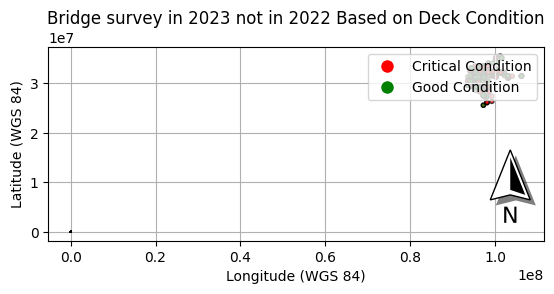

<Figure size 640x480 with 0 Axes>

In [167]:
#Visualize the overlay resultx

fig = plt.figure()
ax1 = fig.add_subplot() #we have multiple layers being added, so when we have to plot multiple layers on the plot, we need to make sure all of them are plotted on the same axis.
texas_wgs84.plot (facecolor='white', edgecolor='black', ax=ax1) #ax=ax1 - overlaping axis. 
texas_wgs84.plot(ax=ax1, color='none', markersize=1)
colors = diff_23_newA['Predicted_DECK_COND_058'].map({0: 'red', 1: 'green'})
plt.scatter(longitude,latitude, c=colors, marker='.', edgecolor='k', alpha=0.7, label='Bridge Locations')
tmap.north_arrow.north_arrow(ax=ax1, location='lower right', rotation={'degrees':0}) 
ax1.set_xlabel('Longitude (WGS 84)')
ax1.set_ylabel('Latitude (WGS 84)')
# Create a custom legend
# Create legend handles manually
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Critical Condition', 
                        markerfacecolor='red', markersize=10)
green_patch = plt.Line2D([0], [0], marker='o', color='w', label='Good Condition', 
                          markerfacecolor='green', markersize=10)

# Add the custom legend to the plot
plt.legend(handles=[red_patch, green_patch], loc='upper right')
plt.grid()
plt.title('Bridge survey in 2023 not in 2022 Based on Deck Condition')
plt.show()
plt.savefig('bridge_2023_Deck_condition.png', dpi=300, bbox_inches='tight')